In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda
from keras.optimizers import Adam
from keras.models import model_from_json
import json
%matplotlib inline
matplotlib.style.use('ggplot')

data_dir = './data'
data_csv = '/driving_log.csv'
model_json = 'model_behavioral_cloning_augmentation.json'
model_weights = 'model_behavioral_cloning_augmentation.h5'

col_names = ['centre', 'left','right','steering_angle','throttle','brake','speed']
training_dat = pd.read_csv('./data/driving_log.csv',names=col_names)
training_dat.head()

,center,left,right,steering,throttle,brake,speed
0,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,2.427794e-07
1,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,6.757399e-07
2,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,9.954655e-07
3,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,1.387092e-06
4,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,/home/chu-chu/self_driving_car_nanodegree/CarN...,0.0,0.0,0,2.046672e-06


In [3]:
# start with the center images only
X_train = training_dat['centre']
X_left  = training_dat['left']
X_right = training_dat['right']
Y_train = training_dat['steering_angle']
Y_train = Y_train.astype(np.float32)
if data_dir=='./data/udacity':
    X_train = X_train.apply(lambda x: data_dir+'/'+x)
X_train.head(),Y_train.head()

(0    /home/chu-chu/self_driving_car_nanodegree/CarN...
 1    /home/chu-chu/self_driving_car_nanodegree/CarN...
 2    /home/chu-chu/self_driving_car_nanodegree/CarN...
 3    /home/chu-chu/self_driving_car_nanodegree/CarN...
 4    /home/chu-chu/self_driving_car_nanodegree/CarN...
 Name: center, dtype: object, 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: steering, dtype: float32)

steering : 0.281267207861


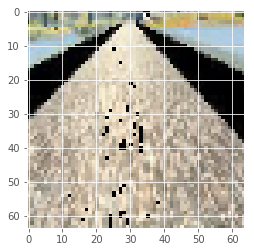

In [4]:
def read_next_image(m,lcr,X_train,X_left,X_right,Y_train):
    # assume the side cameras are about 1.2 meters off the center and the offset to the left or right 
    # should be be corrected over the next dist meters, calculate the change in steering control
    # using tan(alpha)=alpha

    offset=1.2 
    dist=100.0
    steering = Y_train[m]
    if lcr == 0:
        image = plt.imread(X_left[m].strip())
        dsteering = -offset/dist * 360/( 2*np.pi) / 25.0
        steering += dsteering
    elif lcr == 1:
        image = plt.imread(X_train[m].strip())
    elif lcr == 2:
        image = plt.imread(X_right[m].strip())
        dsteering = offset/dist * 360/( 2*np.pi)  / 25.0
        steering += dsteering
    else:
        print ('Invalid lcr value :',lcr )
    
    return image,steering

def random_crop(image,steering=0.0,tx_lower=-20,tx_upper=20,ty_lower=-2,ty_upper=2,rand=True):
    # we will randomly crop subsections of the image and use them as our data set.
    # also the input to the network will need to be cropped, but of course not randomly and centered.
    shape = image.shape
    col_start,col_end =abs(tx_lower),shape[1]-tx_upper
    horizon=60;
    bonnet=136
    if rand:
        tx= np.random.randint(tx_lower,tx_upper+1)
        ty= np.random.randint(ty_lower,ty_upper+1)
    else:
        tx,ty=0,0
    
    #    print('tx = ',tx,'ty = ',ty)
    random_crop = image[horizon+ty:bonnet+ty,col_start+tx:col_end+tx,:]
    image = cv2.resize(random_crop,(64,64),cv2.INTER_AREA)
    # the steering variable needs to be updated to counteract the shift 
    if tx_lower != tx_upper:
        dsteering = -tx/(tx_upper-tx_lower)/20.0
    else:
        dsteering = 0
    steering += dsteering
    
    return image,steering

def random_shear(image,steering,shear_range):
    rows,cols,ch = image.shape
    dx = np.random.randint(-shear_range,shear_range+1)
    #    print('dx',dx)
    random_point = [cols/2+dx,rows/2]
    pts1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])
    pts2 = np.float32([[0,rows],[cols,rows],random_point])
    dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 10.0    
    M = cv2.getAffineTransform(pts1,pts2)
    image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)
    steering +=dsteering
    
    return image,steering

def random_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 1.0 + 0.1*(2*np.random.uniform()-1.0)    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def random_flip(image,steering):
    coin=np.random.randint(0,2)
    if coin==0:
        image,steering=cv2.flip(image,1),-steering
    return image,steering
        

def generate_training_example(X_train,X_left,X_right,Y_train):
    m = np.random.randint(0,len(Y_train))

    lcr = np.random.randint(0,3)

    image,steering = read_next_image(m,lcr,X_train,X_left,X_right,Y_train)

    image,steering = random_shear(image,steering,shear_range=40)
    
    image,steering = random_crop(image,steering,tx_lower=-20,tx_upper=20,ty_lower=-2,ty_upper=2)

    image,steering = random_flip(image,steering)
    image = random_brightness(image)

    
    return image,steering
    

image,steering = generate_training_example(X_train,X_left,X_right,Y_train)
plt.imshow(image)    
print('steering :',steering)

In [5]:
def generate_train_batch(X_train,X_left,X_right,Y_train,batch_size = 32):
    
    batch_images = np.zeros((batch_size, 64, 64, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            x,y = generate_training_example(X_train,X_left,X_right,Y_train)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [6]:
batch_size=200
train_generator = generate_train_batch(X_train,X_left,X_right,Y_train,batch_size)

In [7]:
print('X_train data type :',X_train.dtype)
print('Y_train data type :',Y_train.dtype)

nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (3, 3)
# number of hidden units in the first fully connected layer
nb_fc1=128
nb_fc2=128


model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
model.add(Conv2D(32, 3,3 ,border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
model.add(Conv2D(64, 3,3 ,border_mode='same',subsample=(2,2)))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, 3,3,border_mode='same',subsample=(1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(1))
model.summary()


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

restart=True
if os.path.isfile(model_json) and restart:
    try:
        with open(model_json) as jfile:
            model = model_from_json(json.load(jfile))
            model.load_weights(model_weights)    
        print('loading trained model ...')
    except Exception as e:
        print('Unable to load model', model_name, ':', e)
        raise    

model.compile(optimizer=adam, loss='mse')

X_train data type : object
Y_train data type : float32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
relu2 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

/home/chu-chu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", strides=(2, 2))`
/home/chu-chu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(2, 2))`
/home/chu-chu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", strides=(1, 1))`


In [8]:
nb_epoch=1
history = model.fit_generator(train_generator,
                    samples_per_epoch=20000, nb_epoch=nb_epoch,
                    verbose=1)

json_string = model.to_json()
with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)

/home/chu-chu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/home/chu-chu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=1, steps_per_epoch=20000, verbose=1)`
  after removing the cwd from sys.path.


Epoch 1/1
20000/20000 [==============================] - 4684s - loss: 0.0091  


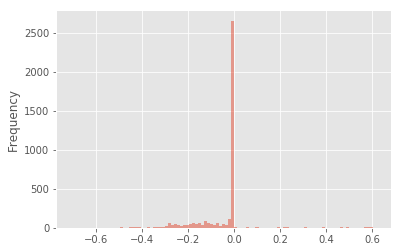

In [9]:
plt.figure();
Y_train.plot.hist(bins=101,alpha=0.5)

In [10]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 1.0 + 0.1*(2*np.random.uniform()-1.0)    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

img = augment_brightness_camera_images(sample_image)
plt.imshow(img)

NameError: name 'sample_image' is not defined

In [ ]:
def random_translation(img,tx_range,ty_range):
    rows,cols,ch = img.shape
    p=10 #pad the image (reflect the boundary)
    tr_x = tx_range*np.random.uniform()-tx_range/2
    tr_y = ty_range*np.random.uniform()-ty_range/2
    #tr_y=-5
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    wrap = cv2.copyMakeBorder(img,p,p,p,p,0)
    img = cv2.warpAffine(wrap,Trans_M,(cols+2*p,rows+2*p))
    img = img[p:p+cols,p:p+rows]
    return img

img1 = random_translation(sample_image,0,0)
img2 = random_translation(sample_image,32,0)
img3 = random_translation(sample_image,32,0)
img4 = random_translation(sample_image,32,32)

images=[img1,img2,img3,img4]

fig, axes = plt.subplots(1,4)
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])